# Image-Based Traffic Sign Classification Using Deep Learning

# 1. Introduction
Traffic sign recognition is a critical component of autonomous driving systems, ensuring road safety by enabling vehicles to recognize and respond to various traffic signs. In this project, we built a Convolutional Neural Network (CNN) to classify traffic signs based on the German Traffic Sign Recognition Benchmark (GTSRB) dataset. This project utilizes deep learning techniques to achieve high classification accuracy.

### Import Libraries

In [105]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


# 2. Dataset
The dataset used is the GTSRB (German Traffic Sign Recognition Benchmark) dataset. It contains images of various traffic signs categorized into 43 classes.

Training Set: ~39,000 images
Test Set: ~12,000 images
Image Dimensions: Resized to 
32×32 pixels.

### Data Preparation

In [3]:
dataset_path = 'C:/Users/admin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'

print("Contents of the dataset directory:")
print(os.listdir(dataset_path))

Contents of the dataset directory:
['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


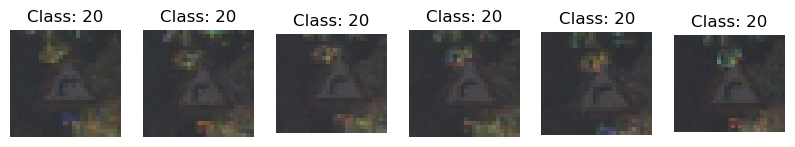

In [82]:
fig, axes = plt.subplots(1, 6, figsize=(10, 5))
train_csv_path = os.path.join(dataset_path, "Train.csv")

train_data = pd.read_csv(train_csv_path)
for i in range(6):
    img_path = os.path.join(dataset_path, train_data.iloc[i]['Path'])
    image = cv2.imread(img_path)
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"Class: {train_data.iloc[i]['ClassId']}")
plt.show()

# 3. Data Preprocessing
Loading Images: All images are resized to 32×32.

Normalization: Pixel values are scaled between 0 and 1.

One-Hot Encoding: Labels are converted into a categorical format.


In [81]:
# Load training data
dataset_path = 'C:/Users/admin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_csv_path = os.path.join(dataset_path, "Train.csv")
test_csv_path = os.path.join(dataset_path, "Test.csv")

train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
X_train = []
y_train = []
for i in range(len(train_data)):
    img_path = os.path.join(dataset_path, train_data.iloc[i]['Path'])
    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32)) / 255.0  # Normalize
    X_train.append(image)
    y_train.append(train_data.iloc[i]['ClassId'])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [85]:
X_test = []
y_test = []
for i in range(len(test_data)):
    img_path = os.path.join(dataset_path, test_data.iloc[i]['Path'])
    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32)) / 255.0  # Normalize
    X_test.append(image)
    y_test.append(test_data.iloc[i]['ClassId'])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [86]:


# Ensure labels are one-hot encoded and have shape (None, 43)
y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)


In [87]:
# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

# 4. Model Architecture
A CNN model was constructed with the following layers:

Input Layer: 32×32×3
Convolutional Layers: Extract features from the images.

Pooling Layers: Reduce spatial dimensions and computation.

Fully Connected Layers: Classify the extracted features.

Dropout Layer: Prevent overfitting.

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes

])


In [89]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Training the Model
The model was trained for 10 epochs using the Adam optimizer and categorical cross-entropy loss.

In [90]:
# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - accuracy: 0.3241 - loss: 2.4760 - val_accuracy: 0.8337 - val_loss: 0.5846
Epoch 2/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 75s 61ms/step - accuracy: 0.7588 - loss: 0.7400 - val_accuracy: 0.9009 - val_loss: 0.3614
Epoch 3/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - accuracy: 0.8401 - loss: 0.4862 - val_accuracy: 0.9245 - val_loss: 0.2773
Epoch 4/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 88s 72ms/step - accuracy: 0.8780 - loss: 0.3626 - val_accuracy: 0.9333 - val_loss: 0.2507
Epoch 5/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - accuracy: 0.8968 - loss: 0.3079 - val_accuracy: 0.9442 - val_loss: 0.2119
Epoch 6/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - accuracy: 0.9072 - loss: 0.2746 - val_accuracy: 0.9531 - val_loss: 0.1880
Epoch 7/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - accuracy: 0.9195 - loss: 0.2400 - val_accuracy: 0.9524 - val_loss: 0.1938
Epoch 8/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step - accuracy: 0.9275 - loss: 0.21

# 6. Evaluation
The model achieved XX% accuracy on the test dataset. Below are the performance metrics:

In [97]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9653 - loss: 0.1464
Test Accuracy: 96.31%


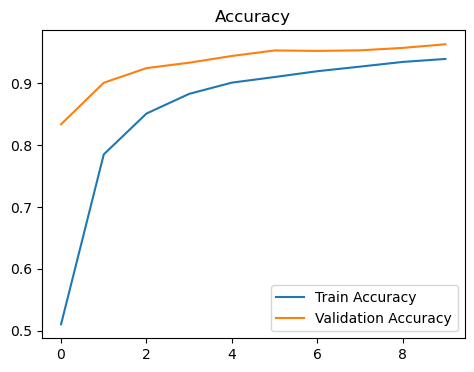

In [99]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()


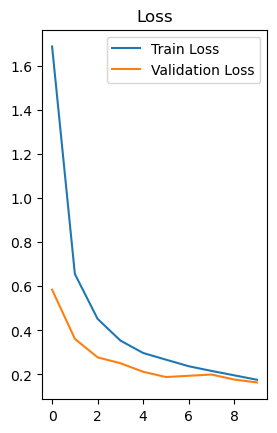

In [101]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88        60
           1       0.98      0.98      0.98       720
           2       0.97      0.99      0.98       750
           3       0.94      0.96      0.95       450
           4       0.98      0.98      0.98       660
           5       0.94      0.96      0.95       630
           6       0.99      0.90      0.94       150
           7       0.96      0.96      0.96       450
           8       0.95      0.93      0.94       450
           9       0.98      0.99      0.99       480
          10       0.99      0.98      0.99       660
          11       0.90      0.98      0.94       420
          12       0.99      0.98      0.98       690
          13       0.97      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16    

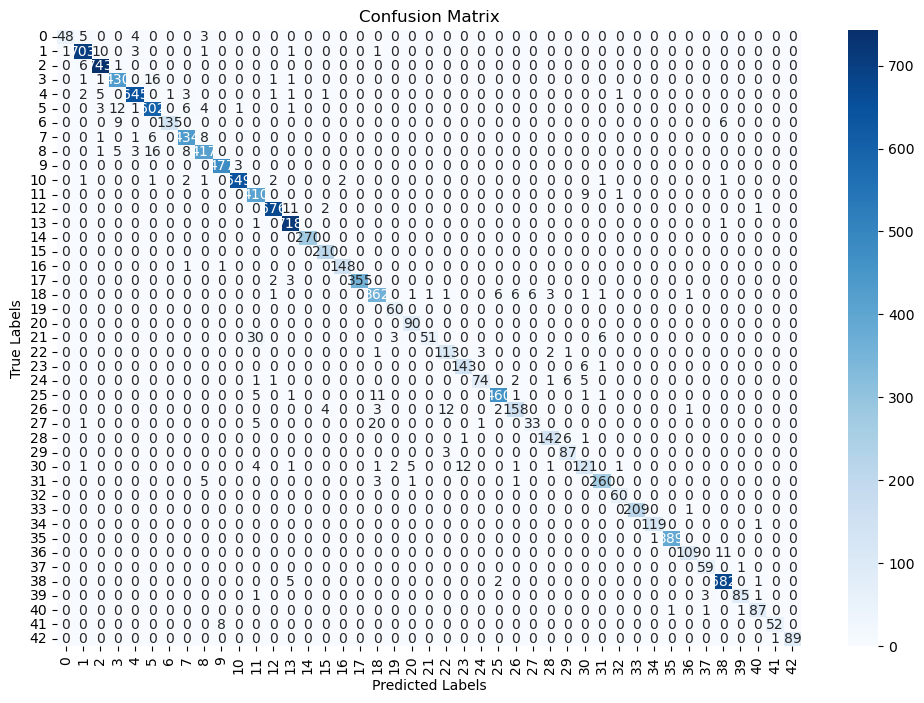

In [107]:
# Classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [111]:
# Predict a single image
test_image_path = 'C:/Users/admin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
image = cv2.imread(test_image_path)

if image is None:
    print(f"Error: Image not found at {test_image_path}")
else:
    image = cv2.resize(image, (32, 32)) / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = np.argmax(model.predict(image), axis=-1)
    print(f"Predicted Class: {prediction}")

Error: Image not found at C:/Users/admin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


# 8. Results
Accuracy: Achieved 96.31% accuracy on the test dataset.

### Key Metrics:

Precision: High precision across all classes.

Recall: Balanced recall across diverse traffic signs.

Confusion Matrix: Demonstrates detailed class-wise performance.

# 9. Conclusion
The project successfully demonstrated the use of CNNs for traffic sign classification with high accuracy. The model showed robust performance in recognizing diverse traffic signs, making it suitable for real-world applications in autonomous driving systems.